In [1]:
### Imports ###
# Data manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

#SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

In [2]:
# Load the data

df= pd.read_csv('../EDA/bikeshare_train_data.csv')
df['total_num_trips'] = df['num_trips']+df['ebike_trips']
df.head()

,Date,Date.1,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,...,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips,total_num_trips
0,0,2017-01-01,497.133333,-2.3,2.2,-0.1,4.5,18.1,0.0,0.0,...,10.0,3.555556,4.296296,3.925926,338025.0,232693.0,0.0,162,1480.333252,162.0
1,1,2017-01-02,498.133333,-6.0,1.4,-2.3,7.4,20.3,0.0,0.0,...,0.0,2.718519,3.688889,3.203704,660054.0,382729.0,0.0,270,1588.333252,270.0
2,2,2017-01-03,499.133333,-7.8,0.4,-3.7,8.2,21.7,0.0,0.0,...,0.0,0.807292,1.791667,1.299479,635395.0,376013.0,0.0,384,1702.333252,384.0
3,3,2017-01-04,501.133333,-8.4,2.2,-3.1,10.6,21.1,0.0,0.0,...,1.0,2.767391,3.643478,3.205435,766082.0,376721.0,0.0,460,1778.333252,460.0
4,4,2017-01-05,502.133333,-6.6,0.7,-3.0,7.3,21.0,0.0,0.0,...,0.0,2.601145,3.524809,3.062977,888222.0,524933.0,0.0,524,1842.333252,524.0


In [3]:
### Split the data into training and test sets ###

#Trig Stuff
train_times = df.index.values
cosines = np.stack([np.cos((2+i)*np.pi*train_times/365) for i in range(10)]  , axis = 1)
sines = np.stack([np.sin((2+i)*np.pi*train_times/365) for i in range(10)]  , axis = 1)
reshape_precip = df.total_precip.values.reshape(-1,1)
reshape_temp = df.mean_dep_temp.values.reshape(-1,1)
# train_features = np.concatenate([train_times.reshape(-1,1),cosines, sines,reshape_precip,reshape_temp], axis = 1)

#Split
X_train = np.concatenate([train_times.reshape(-1,1),cosines, sines,reshape_precip,reshape_temp], axis = 1)
y_train = df.adj_num_trips

X_tt,X_val, y_tt,y_val = train_test_split(X_train, y_train, shuffle = True, random_state = 416, test_size = .2)

In [4]:
# Linear Trig Regression

lt_model = LinearRegression()
lt_model.fit(X_train, df.adj_num_trips)

#?Will want to use 'total_precip' and 'mean_dep_temp' as features in the model

LinearRegression()

RMS: 496.734132621706


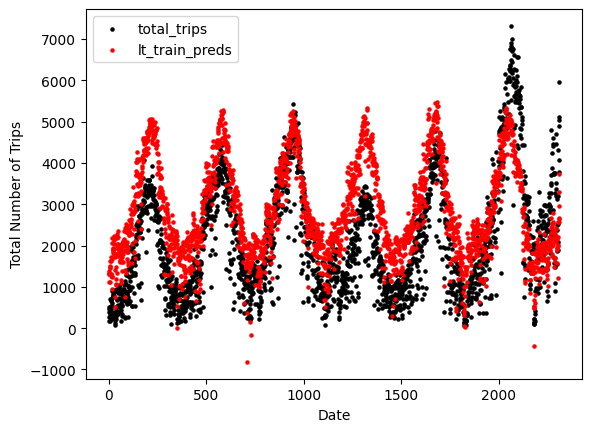

In [5]:
# Plot Trigonometric Model

lt_train_preds = lt_model.predict(X_train)
lt_train_res = df.total_num_trips - lt_train_preds
print('RMS:', np.sqrt(mean_squared_error(df.adj_num_trips, lt_train_preds)))
plt.scatter(df['Date'],df['total_num_trips'],
            color='k',
            s=5,
            label='total_trips'
            )
plt.scatter(df['Date'],lt_train_preds,
            color='r',
            s=5,
            label='lt_train_preds'
            )

plt.xlabel('Date')
plt.ylabel('Total Number of Trips')
plt.legend()
plt.show()

In [6]:
# Figure out regression before SAMIRA

X_train = df[['total_precip','mean_dep_temp']]
y_train = df['adj_num_trips']

X_tt,X_val, y_tt,y_val = train_test_split(X_train, y_train, shuffle = True, random_state = 416, test_size = .2)

#Linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_train)
rms_linreg = np.sqrt(mean_squared_error(y_train, y_pred_linreg))
# KNN regressions
k_values = range(2, 21)
#? Initialize a dictionary to hold the models and their RMS values
knr_models = {}
rms_values = {}

#? Train a KNN model for each k value
for k in k_values:
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    y_pred_knr = knr.predict(X_train)
    
    #? Calculate the RMS for each model
    rms_knr = np.sqrt(mean_squared_error(y_train, y_pred_knr))
    
    #? Store the model and RMS in the dictionaries
    knr_models[k] = knr
    rms_values[k] = rms_knr

print('Best K value:', min(rms_values, key=rms_values.get))
print('RMS:', rms_values[min(rms_values, key=rms_values.get)])

Best K value: 2
RMS: 354.3937973967629


In [8]:
# Begin SARIMA

knr_residuals = y_train - knr_models[2].predict(X_train)

auto_arima(knr_residuals,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32990.171, Time=2.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34222.679, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33746.065, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33005.402, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34220.679, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32991.394, Time=1.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32989.934, Time=1.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32992.931, Time=0.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=33488.444, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32991.569, Time=1.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=33356.344, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=32993.738, Time=1.85 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=32987.984, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32990.986, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

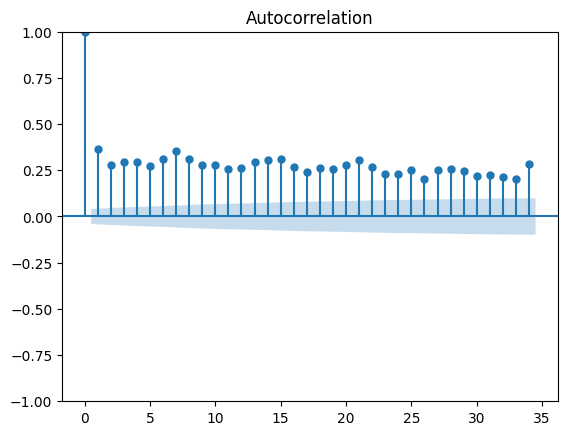

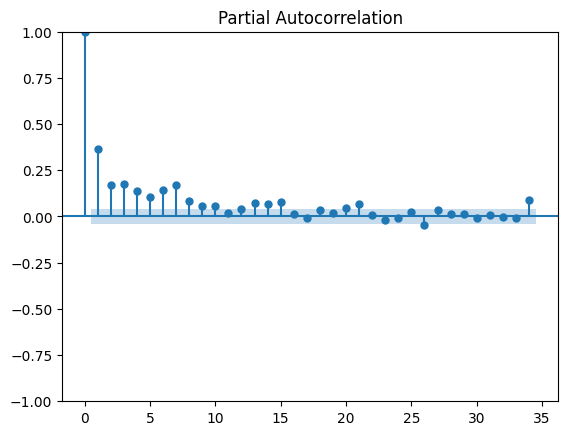

In [15]:
plot_acf(knr_residuals)
plt.show()

plot_pacf(knr_residuals)
plt.show()

In [19]:
# ARIMA Model

arima = sm.ARIMA(knr_residuals, order=(2, 1, 1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          adj_num_trips   No. Observations:                 2311
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -16489.992
Date:                Mon, 27 May 2024   AIC                          32987.984
Time:                        19:50:05   BIC                          33010.964
Sample:                             0   HQIC                         32996.360
                               - 2311                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0818      0.021      3.938      0.000       0.041       0.122
ar.L2         -0.0503      0.020     -2.467      0.014      -0.090      -0.010
ma.L1         -0.9159      0.010    -95.888      0.000      -0.935      -0.897
sigma2      9.283e+04   2458.758     37.753      0.000     8.8e+04    9.76e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.05
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.10
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

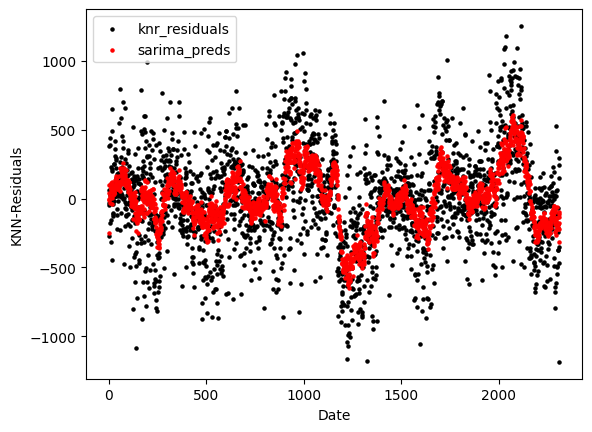

In [14]:
#Plot ARIMA

plt.scatter(df.Date,knr_residuals,
            color='k',
            s=5,
            label='knr_residuals'
            )

plt.scatter(df.Date,arima.fittedvalues,
            color='r',
            s=5,
            label='ARIMA_preds'
            )

plt.xlabel('Date')
plt.ylabel('KNN-Residuals')
plt.legend()
plt.show()

In [16]:
# SARIMA

sarima = sm.ARIMA(knr_residuals, order=(2, 1, 1), seasonal_order=(0,1,1,7)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                   adj_num_trips   No. Observations:                 2311
Model:             ARIMA(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -16434.972
Date:                         Mon, 27 May 2024   AIC                          32879.944
Time:                                 19:49:12   BIC                          32908.654
Sample:                                      0   HQIC                         32890.410
                                        - 2311                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0729      0.021      3.483      0.000       0.032       0.114
ar.L2         -0.0392      0.020     -1.930      0.054      -0.079       0.001
ma.L1         -0.9138      0.010    -94.095      0.000      -0.933      -0.895
ma.S.L7       -1.0000      2.540     -0.394      0.694      -5.978       3.978
sigma2      9.084e+04   2.31e+05      0.394      0.694   -3.61e+05    5.43e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.24
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.07
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.13e+14. Standard errors may be unstable.
"""

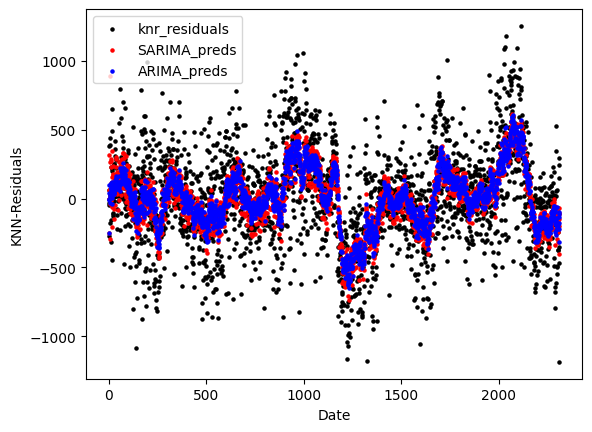

In [20]:
#Plot SARIMA

plt.scatter(df.Date,knr_residuals,
            color='k',
            s=5,
            label='knr_residuals'
            )

plt.scatter(df.Date,sarima.fittedvalues,
            color='r',
            s=5,
            label='SARIMA_preds'
            )
 
plt.scatter(df.Date,arima.fittedvalues,
            color='b',
            s=5,
            label='ARIMA_preds'
            )

plt.xlabel('Date')
plt.ylabel('KNN-Residuals')
plt.legend()
plt.show()
